In [33]:
import pandas as pd
import numpy as np
import os
import string
import datetime
os.getcwd()
import glob



In [26]:
def convert_mm(value):
    #length in mm transformed to float
    try:
        new_value = value.replace(' mm','')
        return float(new_value)    
    except AttributeError:
        return np.NaN

In [4]:
def convert_exposure(value):
    #length in mm transformed to float
    try:
        list_string=value.split('/')
        if (len(list_string)==1):
            return float(value)
        else:
            return float(list_string[0])/float(list_string[1])
    except AttributeError:
        #print ('WTF',value)
        return np.NaN
    #return float(0)
        

In [5]:
def remove_full_path(value):
    #all pictures originate from a Pictures folder, remove the full path
    #including Pictures
    try:
        list_string=value.split('/Pictures')
        return list_string[1]
    except AttributeError:
        return np.NaN

In [6]:
def funcDayPeriod(filename):
    search_night=["bei Nacht",'Sternenhimmel',"Mondschein","Mond","Ice and Snow/"]
    search_night_special=["Lumiere","euerwerk","Firework","Freudenfeuer"]
    search_twilight=["bei anbrechender Nacht","Abenddaemmerung","Morgendaemmerung","Sonnenaufgang"]
    if any (x in filename for x in search_night):
        return -1
    elif any(x in filename for x in search_night_special):
         return 0
    elif any(x in filename for x in search_twilight):
        return 3
    elif "bei Sonnenuntergang" in filename:
        return 2
    else:
        return 1

In [7]:
def funcComposite(filename):
    if "Panorama." in filename:
        return 1
    else:
        return 0

In [8]:
def funcMovie(filename):
    search_file_names=[".JPG",".jpg",".JPEG",".jpeg"]
    if any(x in filename for x in search_file_names):
        return 0
    else:
        return 1

In [9]:
def funcTimeZoneCorrectionNYCBias(value,filename,modelname,data_min,data_max):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            #date is ordered by 
            #date_orig = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            datemin = datetime.datetime.strptime(data_min,"%b %d %a ,%Y, %H:%M:%S") 
            datemax = datetime.datetime.strptime(data_max,"%b %d %a ,%Y, %H:%M:%S") 
            if modelname=="SP500UZ":
                if(date>datemin and date<datemax):
                #never changed timezone after getting back from NYC, all messed up
                    date=date+datetime.timedelta(hours=6)
            return date.strftime("%b %d %a ,%Y, %H:%M:%S")
    except AttributeError:
        return np.NaN

In [10]:
def funcTimeZoneCorrection(value,filename,modelname):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            search_names_NYC_time_zone=["- Philadelphia,","New York City,","Newark,","Washington Airport"]
            search_names_London_time_zone_CANON600D=["Dublin & Nordirland/P","120830-120909 - Portugal/","Suedengland/","141212-141214 - London/","Greater London"]
            search_names_Istanbul_time_zone_CANON600D=["41023-141027 - Istanbul/","150828-150912 Sankt Petersburg/"]
            search_names_pacific_time_zone_CANON600D=["150613 - Los Angeles/","USA/P818"," - Grand Canyon Village, "," - Boulder City, "," - Las Vegas, "]
            search_names_China_time_zone_CANON80D=["180101 China/","/171230 Shanghai"," - China, "]
            search_names_EastEurope_time_zone_CANON80D=["170603 Athen/","171006 Tallinn ","/170414 Kiev"," - Tuerkei, "," - Irak, "," - Kuwait"," - Qatar, "]
            search_names_London_time_zone_CANON80D=[" - Saudi-Arabien,","/190413-190417 Suedostengland/"," - United Kingdom - ","/171110 Marrakesch/","170915 London/P","/180602 UK/"]
            search_names_Iceland_time_zone_CANON80D=[" - Island, ","/180328 Island/"]
            search_names_Gulf_time_zone_CANON80D=[" - Island, "," - Dubai, "]
            search_names_Pakistan_time_zone_CANON80D=[" - Pakistan, "]
            search_names_Korea_time_zone_CANON80D=[" - Paju, "," - Suwon, "," - Seoul, "," - Busan,"," - Incheon, "," - Gyeongju, "," - Gwanju, "]
            if modelname=="SP500UZ":
                hour_bias=0
                data_max_olympus=datetime.datetime.now()
                date_max_olympus=datetime.date(2008,9,1)
                if(date.date()<date_max_olympus):
                    hour_bias=24
                #no change of default time, thus London time is an hour too late
                if "London/P" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)+datetime.timedelta(hours=hour_bias)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_NYC_time_zone):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=6)+datetime.timedelta(hours=hour_bias)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif " Chicago - Edit2012/P" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=7)+datetime.timedelta(hours=hour_bias)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")      
                else:
                    value_new=date+datetime.timedelta(hours=hour_bias)
                    return value_new.strftime("%b %d %a ,%Y, %H:%M:%S")
            if modelname=="Canon EOS 600D":
                #all of EOS600D done including 2015
                if any(x in filename for x in search_names_London_time_zone_CANON600D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_Istanbul_time_zone_CANON600D):
                    date=date+datetime.timedelta(hours=1)
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_pacific_time_zone_CANON600D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=9)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "- Chicago, " in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=7)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif " - Washington D.C., " in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=6)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "/160813 - USA/" in filename:
                    #remaining 2016 US trip times
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=8)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "161205 - Japan/" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=7)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                else:
                    #change to default summer time
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
            if modelname=="Canon PowerShot S110":  
                 #all running on summer time
                if any(x in filename for x in search_names_London_time_zone_CANON600D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=2)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "41023-141027 - Istanbul/" in filename:
                    #for Istanbul timezone was not aligned with CANON EOS600D
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "150613 - Los Angeles/" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=10)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "/2016/" in filename:
                    if "161205 - Japan/" in filename:
                        date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                        date=date+datetime.timedelta(hours=6)
                        return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                    else:
                        #change to default summer time
                        date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                        date=date-datetime.timedelta(hours=1)
                        return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                else:
                    #change to default summer time
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
            if modelname=="Canon EOS 80D":
                if any(x in filename for x in search_names_China_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=6)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_EastEurope_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_London_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif " - Groenland" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=4)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S") 
                elif any (x in filename for x in search_names_Iceland_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=2)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S") 
                elif "/170609 USA/" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=8)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")  
                elif any(x in filename for x in search_names_Gulf_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=2)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_Pakistan_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=3)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_Korea_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=7)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                else:
                    #always on summer time
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
    except AttributeError:
        return np.NaN

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


dataframe_list=[]

data_max=datetime.datetime.now()
datamax=data_max.strftime("%b %d %a ,%Y, %H:%M:%S")
data_min=datetime.datetime.now()
datamin=data_min.strftime("%b %d %a ,%Y, %H:%M:%S")

print(datamin,datamax)

#push-back day related periods, 1 for day,2 for sunset,3 for dusk and daw,sunrise, 0 for night
for input in range(2006,2020):
    #print("get to year",input)
    df=pd.read_csv("outputEXIFcsvs/PhotoEXIFDataDayType_%s.csv"%(str(input)))
    #push back year index as additional list 
    #print(df.columns,df.head)
    df['SourceFile']=df['SourceFile'].apply(remove_full_path)    
    df['FocalLength']=df['FocalLength'].apply(convert_mm) 
    df['ExposureTime']=df['ExposureTime'].apply(convert_exposure)
    df['DateTimeOriginal']=df['DateTimeOriginal'].fillna('missing')
    df['year']=int(input)
    df['dayperiod']=df.apply(lambda x: funcDayPeriod(x['SourceFile']), axis=1)
    df['CompositePhoto']=df.apply(lambda x: funcComposite(x['SourceFile']), axis=1)
    df['Movie']=df.apply(lambda x: funcMovie(x['SourceFile']), axis=1)
    df.rename(columns={'DateTimeOriginal':'Date','FocalLength':'FocalLength in mm'},inplace=True) 
    df['Date']=df.apply(lambda x: funcTimeZoneCorrection(x['Date'],x['SourceFile'],x['Model']), axis=1)
    df['Date']=df['Date'].fillna('missing')
    total_rows=df['SourceFile'].count()
    if(input==2009 or input ==2010):
        if input==2009:
            test=df.loc[df['SourceFile'].str.contains("P7080022 - New York City")]
            datamin=df.at[test.index.values.astype(int)[0],"Date"]   
            df['Date']=df.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
        elif input==2010:    
            test=df.loc[df['SourceFile'].str.contains("P8270068 - Le Locle, unterirdische Muehlen")]
            #print("correction should end somewhere here 2010",test,"index is",test.index.values.astype(int)[0])
            datamax=df.at[test.index.values.astype(int)[0],"Date"]   
            df['Date']=df.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
    df = df.replace(r'^\s+$', np.nan, regex=True)
    
    dataframe_list.append(df)
    #df['Date']=df[df.Date!='missing']
    #date_stripped=df[~df['Date'].str.contains("missing")]
    #print("rows per year", input,total_rows)
    #print(df.dtypes)
    #df['Date'] = pd.to_datetime(date_stripped['Date'], format="%b %d %a ,%Y, %H:%M:%S")
   # fig = plt.figure(figsize = (10,6))
    #ax = fig.add_subplot(111)

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %a ,%Y, %H:%M:%S'))
    #df["Date"].plot(ax=ax, kind='bar')
    #plt.plot(df['Date'])
    #plt.show()
    #hist = df.hist()
 
combine_all_data=pd.DataFrame(dataframe_list[0]) 
#print(combine_all_data.head)
#print("now for the rest")
dataframe_list.pop(0)
for data in dataframe_list:
    #print(data.head)
    combine_all_data=pd.concat([combine_all_data,data],ignore_index=True,sort=False)
    #print(combine_all_data.head)
    
combine_all_data.to_csv(r'EXIFDataCombinedCameras_2006_to_2019_DateLocalTime.csv')
#print(combine_all_data.head)

Aug 19 Mon ,2019, 18:11:06 Aug 19 Mon ,2019, 18:11:06


NameError: name 'remove_full_path' is not defined

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


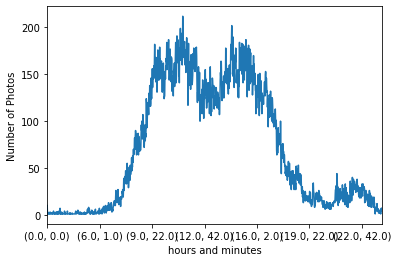

Unnamed: 0                      int64
SourceFile                     object
Date                   datetime64[ns]
FocalLength in mm             float64
ExposureTime                  float64
Model                          object
ISO                           float64
Aperture                       object
LightValue                    float64
year                            int64
dayperiod                       int64
CompositePhoto                  int64
Movie                           int64
MeasuredEV                    float64
MeasuredRGGB                   object
WB_RGGBLevelsAsShot            object
ColorTemperature              float64
ColorTempDaylight             float64
TimeZone                       object
DaylightSavings                object
TimeZoneCity                   object
pictureCount                    int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89503 entries, 0 to 91787
Data columns (total 22 columns):
Unnamed: 0             89503 non-null int

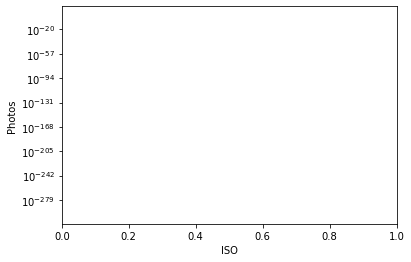

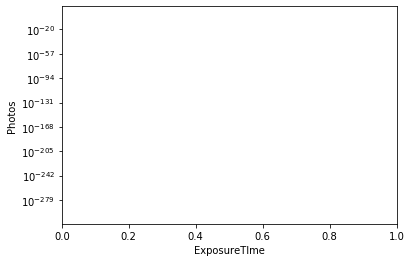

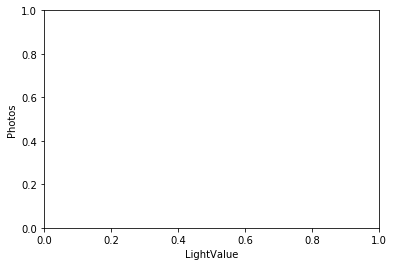

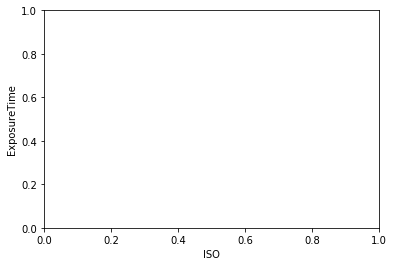

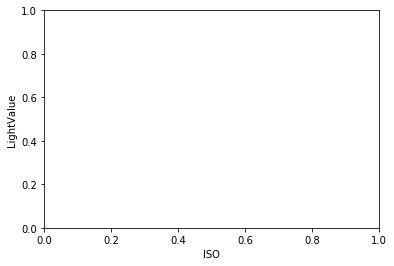

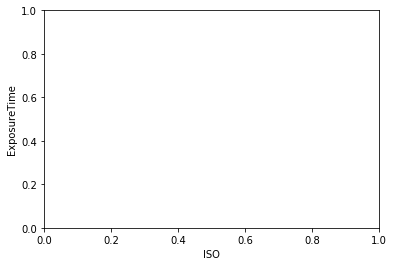

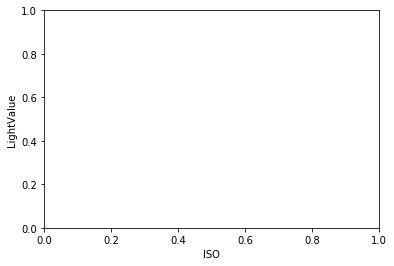

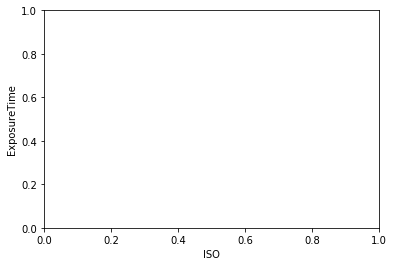

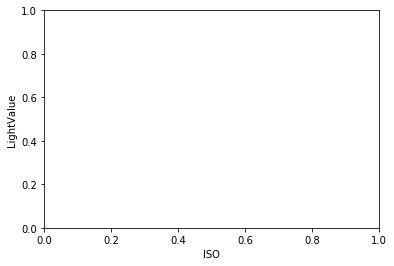

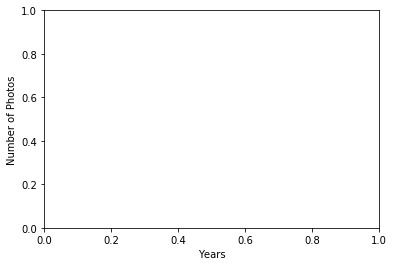

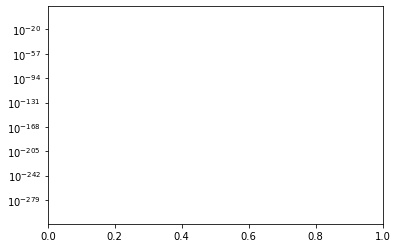

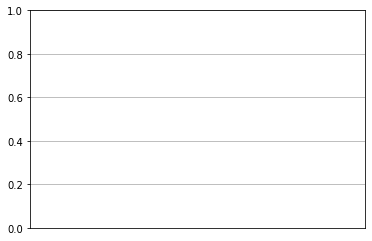

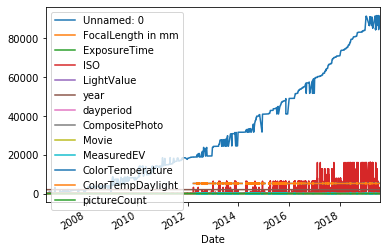

for month 1 Date
0.0     436
1.0     805
2.0     741
3.0     607
4.0     679
5.0     872
6.0    1544
Name: pictureCount, dtype: int64
for month 2 Date
0.0     24
1.0     34
3.0    143
4.0     59
5.0    649
6.0    810
Name: pictureCount, dtype: int64
for month 3 Date
0.0    1226
1.0     905
2.0     827
3.0     876
4.0    1170
5.0    2080
6.0    2288
Name: pictureCount, dtype: int64
for month 4 Date
0.0    1267
1.0     715
2.0     791
3.0     960
4.0     920
5.0    2822
6.0    2494
Name: pictureCount, dtype: int64
for month 5 Date
0.0     936
1.0     245
2.0      26
3.0     878
4.0    1295
5.0    2607
6.0    2681
Name: pictureCount, dtype: int64
for month 6 Date
0.0     430
1.0     364
2.0     588
3.0     493
4.0     870
5.0    1506
6.0    2861
Name: pictureCount, dtype: int64
for month 7 Date
0.0    1221
1.0     960
2.0    1219
3.0    1485
4.0    1221
5.0    3171
6.0    3395
Name: pictureCount, dtype: int64
for month 8 Date
0.0     560
1.0     508
2.0     389
3.0     667
4.0    1365
5.0

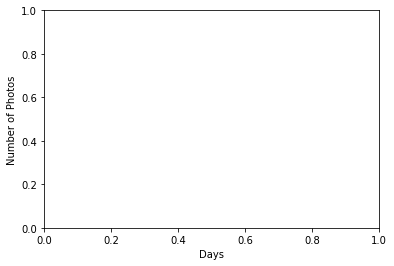

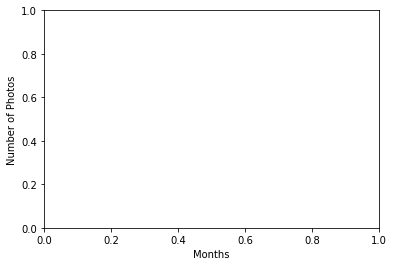

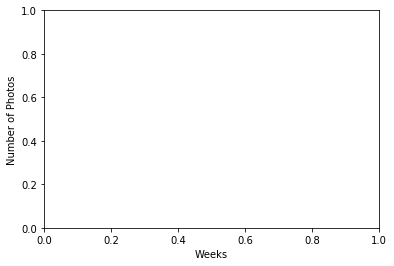

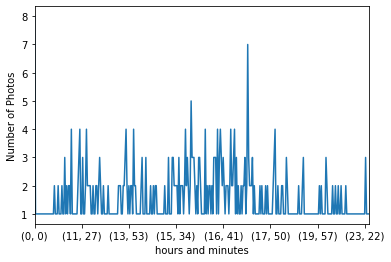

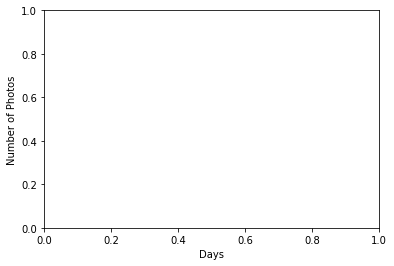

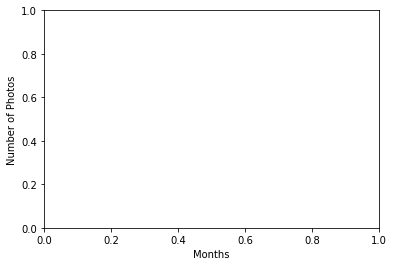

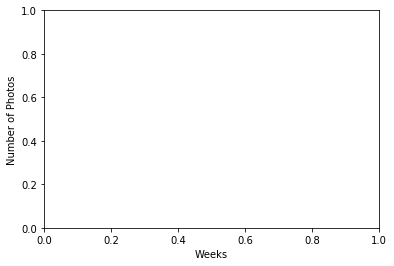

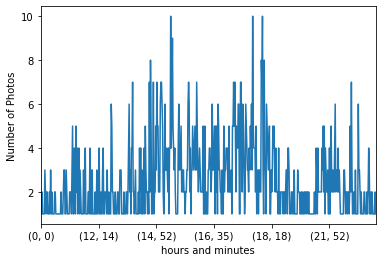

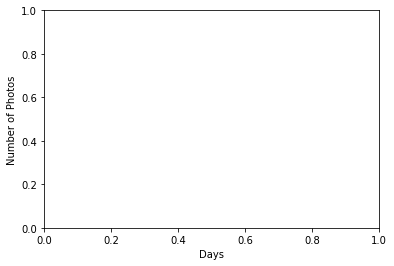

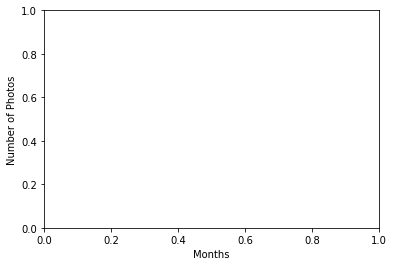

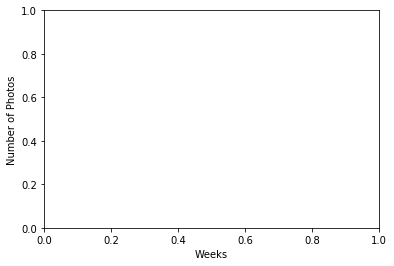

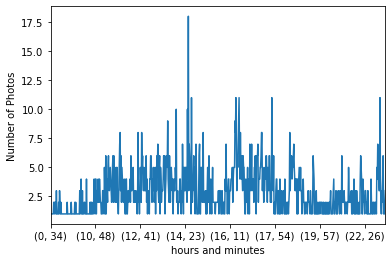

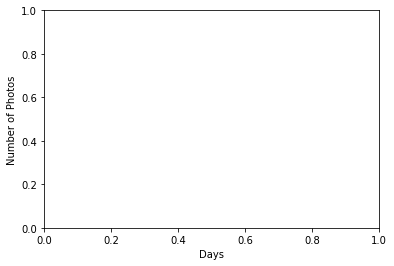

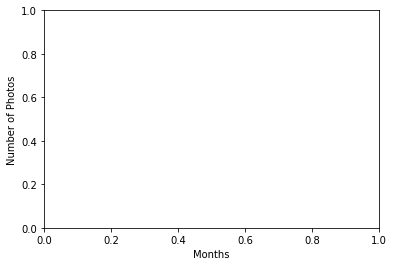

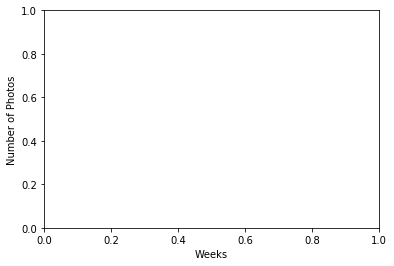

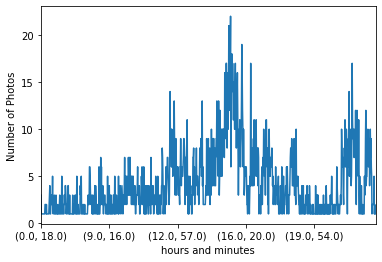

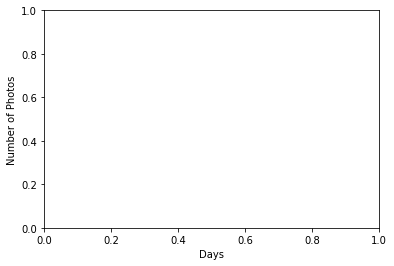

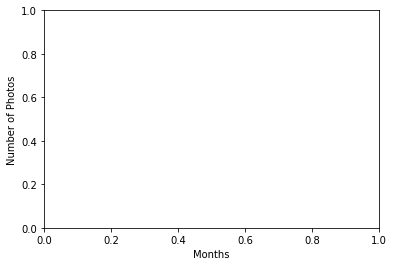

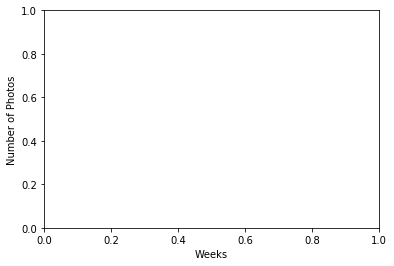

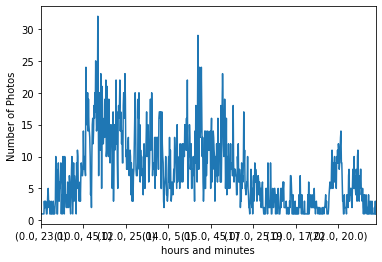

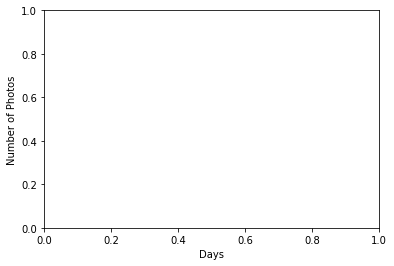

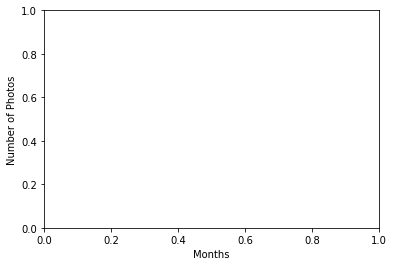

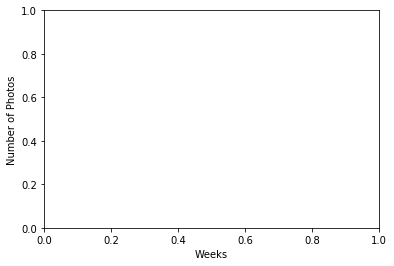

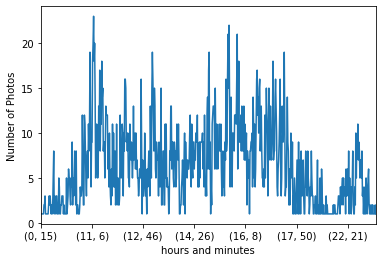

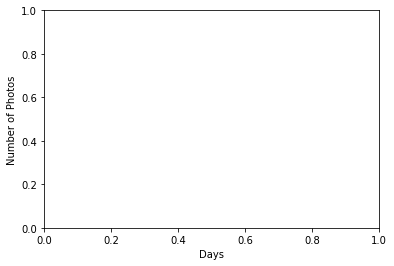

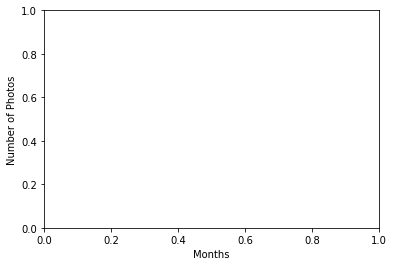

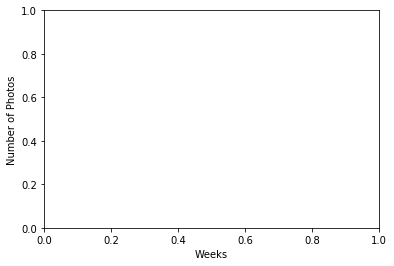

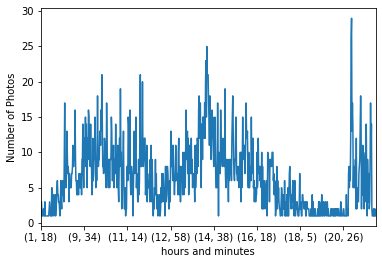

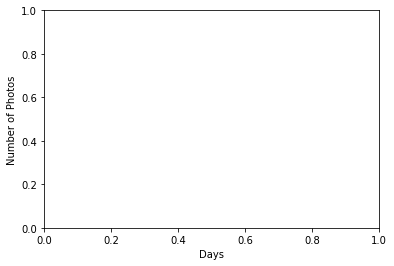

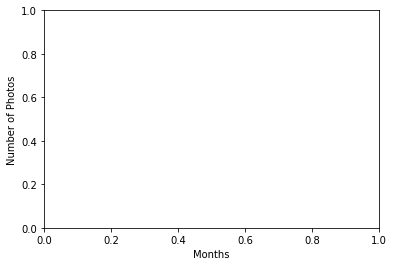

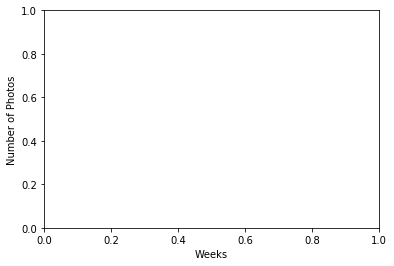

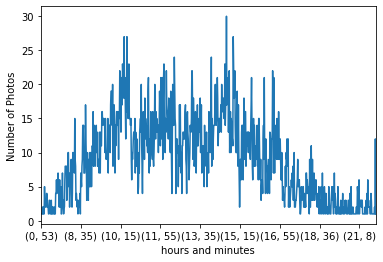

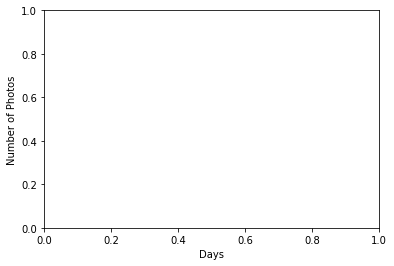

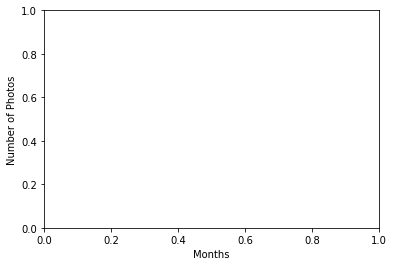

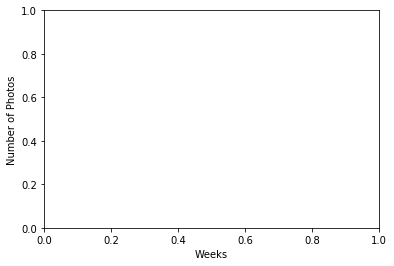

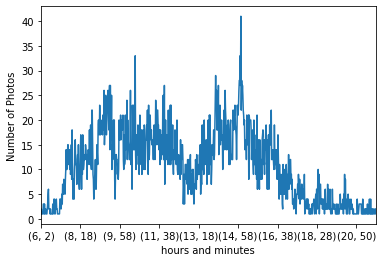

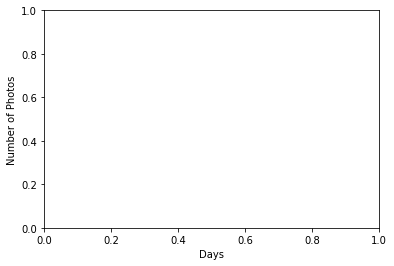

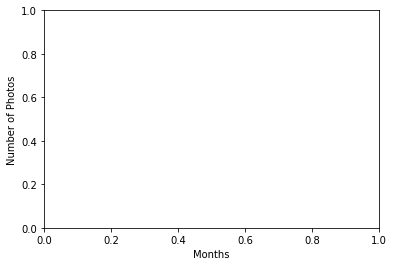

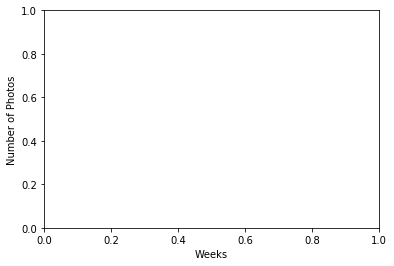

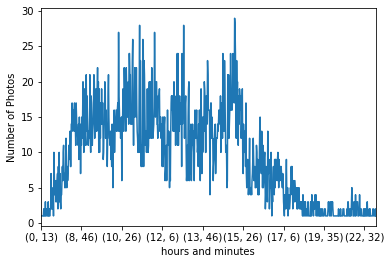

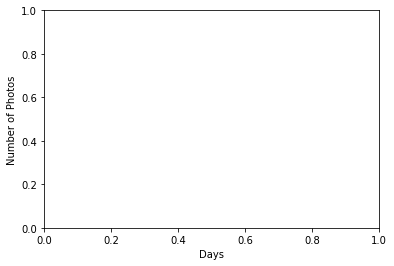

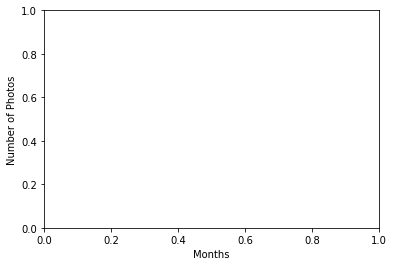

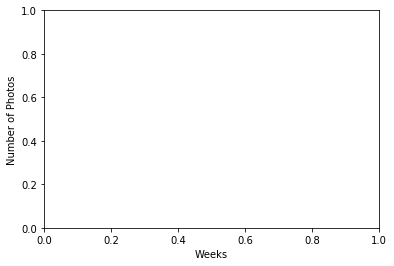

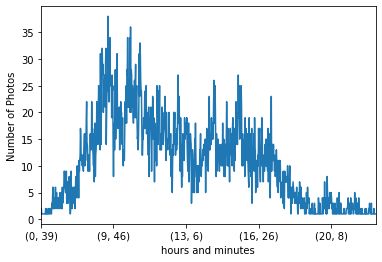

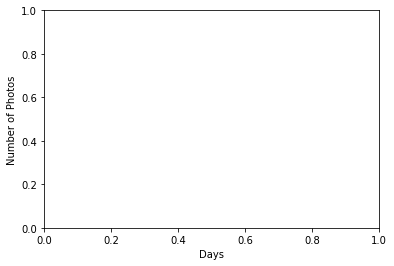

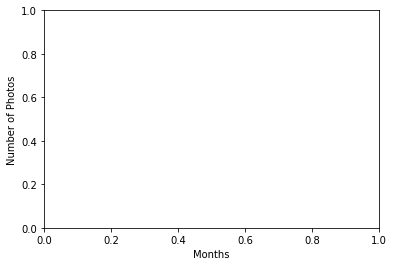

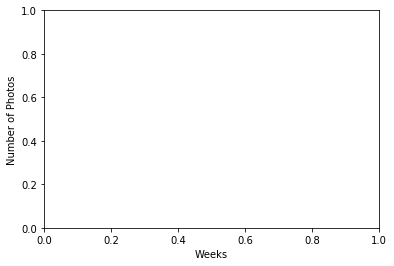

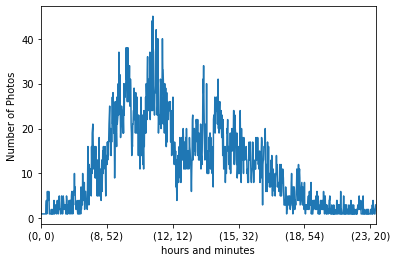

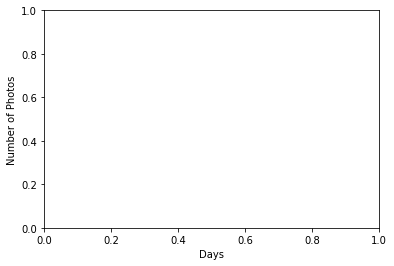

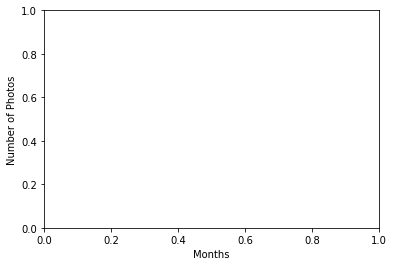

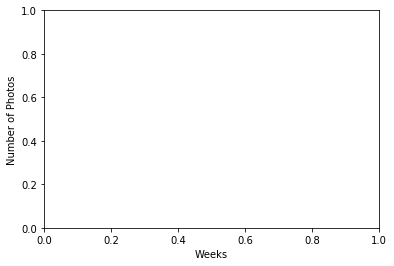

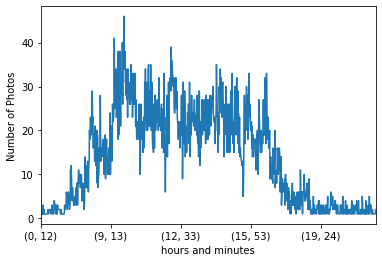

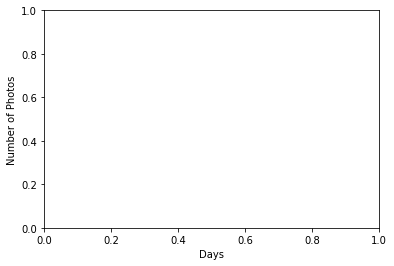

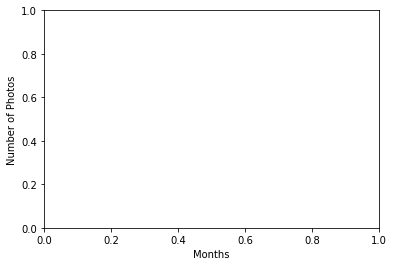

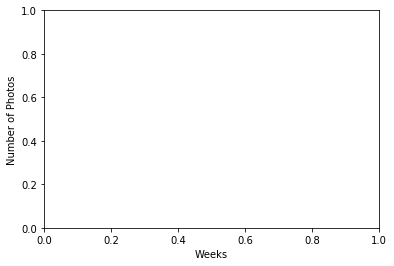

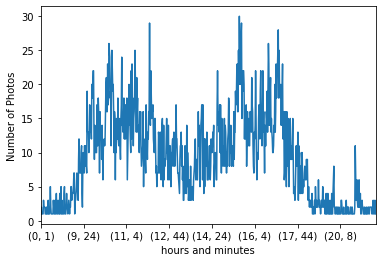

Unnamed: 0               int64
SourceFile              object
Date                    object
FocalLength in mm      float64
ExposureTime           float64
Model                   object
ISO                    float64
Aperture                object
LightValue             float64
year                     int64
dayperiod                int64
CompositePhoto           int64
Movie                    int64
MeasuredEV             float64
MeasuredRGGB            object
WB_RGGBLevelsAsShot     object
ColorTemperature       float64
ColorTempDaylight      float64
TimeZone                object
DaylightSavings         object
TimeZoneCity            object
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89503 entries, 0 to 91787
Data columns (total 22 columns):
Unnamed: 0             89503 non-null int64
SourceFile             89503 non-null object
Date                   89455 non-null datetime64[ns]
FocalLength in mm      89503 non-null float64
ExposureTime           89503 non-null 

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


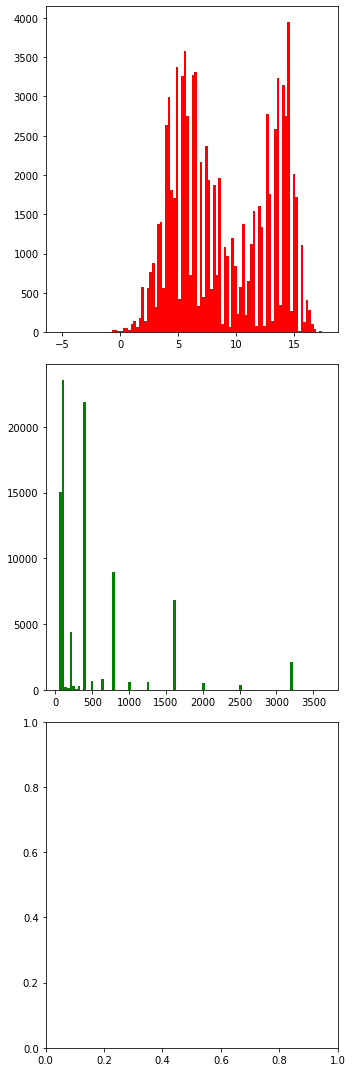

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
from math import log
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm

dataframe_list=[]

data_max=datetime.datetime.now()
datamax=data_max.strftime("%b %d %a ,%Y, %H:%M:%S")
data_min=datetime.datetime.now()
datamin=data_min.strftime("%b %d %a ,%Y, %H:%M:%S")


df=pd.read_csv("EXIFDataCombinedCameras_2006_to_2019_DateLocalTimeFinal.csv")
#df['Aperture']=df['Aperture'].
#print(df.info())
df_new=df.dropna(axis=0, how='all', subset=['ISO','ExposureTime','LightValue','FocalLength in mm'])
df_new=df_new[df_new['Date']!='missing']
df_new['Date']=pd.to_datetime(df_new['Date'],format='%b %d %a ,%Y, %H:%M:%S')
df_new['pictureCount']=int(1)
df_new=df_new[df_new['Movie']!=1]
df_new=df_new[df_new['CompositePhoto']!=1]
df_new.groupby([df_new['Date'].dt.hour, df_new['Date'].dt.minute]).pictureCount.sum().plot()
#df_new_1.T.plot(kind='bar')
#plt.hist(grouped_h_min[1].pictureCount)
plt.xlabel('hours and minutes')
plt.ylabel('Number of Photos')
plt.savefig("EXIFDataPlots/photosPerWeekHourMinutes.pdf")
plt.show()
plt.close()
df_day=df_new[df_new['dayperiod']==1]
df_night=df_new[df_new['dayperiod']!=1]
#df_new.astype({'ISO': 'float32'}).dtypes
#df_new=df_new.dropna(axis=0, how='all', subset=['ISO','ExposureTime','LightValue','FocalLength in mm'])
#df_new=df_new[df_new['Date']!='missing']
print(df_new.dtypes)
#fails
#df_new['Date']=pd.Timestamp(df_new['Date'],format='%b %d %a ,%Y, %H:%M:%S')
#d_low=datetime.date(2011, 12, 31)
print(df_new.info())
plt.yscale('log')
plt.xlabel('ISO')
plt.ylabel('Photos')
##plt.hist(df_new['ISO'], bins=100, rwidth=1.5,color="k")
##plt.savefig('EXIFDataPlots/ISOValues.pdf')
plt.show()
plt.close()
plt.yscale('log')
plt.xlabel('ExposureTIme')
plt.ylabel('Photos')
##plt.hist(df_new['ExposureTime'], bins=100, rwidth=1.5,color="k")
##plt.savefig('EXIFDataPlots/ExposureTimeValues.pdf')
plt.show()
plt.close()
#plt.yscale('log')
plt.xlabel('LightValue')
plt.ylabel('Photos')
##plt.hist(df_new['LightValue'], bins=100, rwidth=1.5,color="k")
##plt.savefig('EXIFDataPlots/LightValues.pdf')
plt.show()
plt.close()
plt.xlabel('ISO')
plt.ylabel('ExposureTime')
##plt.hist2d(df_night['ISO'],df_night['ExposureTime'], bins=[100,100],range=[[80,16000],[0,0.75]],norm = colors.LogNorm())
##plt.savefig('EXIFDataPlots/PhotosIsoVsExposureValueNotDay.pdf')
##plt.colorbar()
plt.show()
plt.close()
plt.show()
plt.close()
plt.xlabel('ISO')
plt.ylabel('LightValue')
##plt.hist2d(df_night['ISO'],df_night['LightValue'], bins=[100,100],range=[[80,16000],[-0.5,15.5]],norm = colors.LogNorm())
##plt.savefig('EXIFDataPlots/PhotosIsoVsLightValueNotDay.pdf')
##plt.colorbar()
plt.show()
plt.close()
plt.xlabel('ISO')
plt.ylabel('ExposureTime')
##plt.hist2d(df_day['ISO'],df_day['ExposureTime'], bins=[100,100],range=[[80,16000],[0,0.75]],norm = colors.LogNorm())
##plt.savefig('EXIFDataPlots/PhotosIsoVsExposureValueDay.pdf')
##plt.colorbar()
plt.show()
plt.close()
plt.show()
plt.close()
plt.xlabel('ISO')
plt.ylabel('LightValue')
##plt.hist2d(df_day['ISO'],df_day['LightValue'], bins=[100,100],range=[[80,16000],[-0.5,15.5]],norm = colors.LogNorm())
##plt.savefig('EXIFDataPlots/PhotosIsoVsLightValueDay.pdf')
##plt.colorbar()
plt.show()
plt.close()
plt.xlabel('ISO')
plt.ylabel('ExposureTime')
##plt.hist2d(df_new['ISO'],df_new['ExposureTime'], bins=[100,100],range=[[80,16000],[0,0.75]],norm = colors.LogNorm())
##plt.savefig('EXIFDataPlots/PhotosIsoVsExposureValue.pdf')
##plt.colorbar()
plt.show()
plt.close()
plt.show()
plt.close()
plt.xlabel('ISO')
plt.ylabel('LightValue')
##plt.hist2d(df_new['ISO'],df_new['LightValue'], bins=[100,100],range=[[80,16000],[-0.5,15.5]],norm = colors.LogNorm())
##plt.savefig('EXIFDataPlots/PhotosIsoVsLightValue.pdf')
##plt.colorbar()
plt.show()
plt.close()
#plt.figure(figsize=(12, 6))
d_lim_tot_low=datetime.date(2005,12,31)
d_lim_tot_high=datetime.date(2020,1,1)
limits_tot=[mdates.date2num(d_lim_tot_low),mdates.date2num(d_lim_tot_high)]
plt.xlabel('Years')
plt.ylabel('Number of Photos')
##plt.hist(df_new['Date'], bins=14, rwidth=0.8,range=limits_tot,color="k")
##plt.savefig('EXIFDataPlots/PhotosVsYears.pdf')
plt.show()
plt.close()

df_new_eos80D=df_new[df_new['Model']=="Canon EOS 600D"]
plt.yscale('log')
##plt.hist(df_new_eos80D['FocalLength in mm'], bins=100, rwidth=1.5,color="k")
##plt.savefig('EXIFDataPlots/FocalLengthCanonEOS600D.pdf')
plt.show()
plt.close()

fig, ax = plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
##plt.savefig('EXIFDataPlots/PhotosVsTimeWithTrend.pdf')
plt.show()
plt.close()
df_new_2=df_new[df_new['Date'].dt.month==1]
df_new_2.to_csv(r'EXIFDataTestJanuary.csv')
date_index=df_new.set_index('Date')
date_index.plot()
plt.show()
weekly = date_index.resample('W').sum()
df_new_2.to_csv(r'test_jan.csv')
weekly.to_csv(r'test_weeklyresample.csv')
df_day_group=df_new_2.groupby(df_new_2["Date"].dt.weekday)
for ind in range (1,13):
    ##df_new[df_new['Date'].dt.month==ind].groupby(df_new["Date"].dt.weekday).pictureCount.sum().plot(kind='bar')
    print('for month',ind,df_new[df_new['Date'].dt.month==ind].groupby(df_new["Date"].dt.weekday).pictureCount.sum())
    plt.xlabel('Days')
    plt.ylabel('Number of Photos (month=%s)'%str(ind))
    ##plt.savefig("EXIFDataPlots/photosPerWeekdayMonth%s.pdf"%str(ind))
    plt.close()
for ind in range (2006,2020):
    ##df_new[df_new['Date'].dt.year==ind].groupby(df_new["Date"].dt.weekday).pictureCount.sum().plot(kind='bar')
    print('for year',ind,df_new[df_new['Date'].dt.month==ind].groupby(df_new["Date"].dt.weekday).pictureCount.sum())
    plt.xlabel('Days')
    plt.ylabel('Number of Photos (year=%s)'%str(ind))
    ##plt.savefig("EXIFDataPlots/photosPerWeekdayYear%s.pdf"%str(ind))
    plt.close()

#print(df_day_group['pictureCount'].sum())
#df_day_group['pictureCount'].sum(axis=0).plot()
# case 1
#plt.plot(df_day_group.Date, df_day_group['pictureCount'].sum())
#plt.show()
# case 2
#plt.plot(df_day_group.index, df_day_group.sum(axis=1))
# case 3
#plt.plot(df_day_group.index, df_day_group['pictureCount'].sum(axis=1))
#plt.hist(df_day_group['Date'], bins=7, rwidth=0.8,range=[-0.5,6.5],color="k")
#plt.savefig('EXIFDataPlots/PhotosVsWeekday.pdf')
#plt.show()
#plt.close()
#df_day_group.to_csv(r'test_grouping.csv')
#print(weekly)
#print (df_new_2)

#fig, axs = plt.subplots(1, 3, figsize=(5, 20), sharex=False, sharey=False,tight_layout=True)
#axs[0, 2].set_xlim([mdates.date2num(d_lim_tot_low),mdates.date2num(d_lim_tot_high)])
#axs[0, 2].set(xlabel='Year',ylabel='Number of Photos')
#fig=plt.subplots(1,3)
for year in range(2006,2020): 
    df_new_1=df_new[(df_new['year']==year)]
    #plt.figure(figsize=(12, 6))
    #plt_months=plt.figure(figsize=(12, 6))
    d_lim_low=datetime.date(int(year-1), 12, 31)
    d_lim_high=datetime.date(int(year+1), 1, 1)
    #axs[0, 1].set_xlim([mdates.date2num(d_lim_low),mdates.date2num(d_lim_high)])
    #axs[0, 1].set(xlabel='Months',ylabel='Number of Photos')
      
    #df_new_1=df_new_1[df_new_1['Date']<pd.Timestamp(int(year+1), 1, 1,0)]
    #df_new_1=df_new_1[df_new_1['Date']>pd.Timestamp(int(year), 1, 1,0)]
    limits=[mdates.date2num(d_lim_low),mdates.date2num(d_lim_high)]
    #no photo taken on Feb 29 so far
    ##plt.hist(df_new_1['Date'], bins=365, rwidth=0.8,range=limits,color="r")
    plt.xlabel('Days')
    plt.ylabel('Number of Photos')
    ##plt.savefig("EXIFDataPlots/photosPerDayYear%s.pdf"%(str(year)))
    plt.show()
    plt.close()
    ##plt.hist(df_new_1['Date'], bins=12, rwidth=0.8,range=limits,color="b")
    plt.xlabel('Months')
    plt.ylabel('Number of Photos')
    ##plt.savefig("EXIFDataPlots/photosPerMonthsYear%s.pdf"%(str(year)))
    plt.show()
    plt.close()
    ##plt.hist(df_new_1['Date'],bins=52, rwidth=0.8,range=limits,color="k")
    #df_new_1.T.plot(kind='bar')
    plt.xlabel('Weeks')
    plt.ylabel('Number of Photos')
    ##plt.savefig("EXIFDataPlots/photosPerWeekYear%s.pdf"%(str(year)))
    plt.show()
    plt.close()
    #plt.hist(df_new_1['Date'].dt.weekday(), bins=7, rwidth=0.8,range=[-0.6,6.5,color="b")
    #plt.xlabel('Weekdays')
    #plt.ylabel('Number of Photos')
    #plt.savefig("EXIFDataPlots/photosPerDaysYear%s.pdf"%(str(year)))
    #plt_days.xlabel('Days')
    #plt_days.ylabel('Number of events')
    #plt_months.hist(df_new_1['Date'], bins=12, rwidth=0.8,range=limits)
    #plt_months.xlabel('Months')
    #plt_months.ylabel('Number of events')
    #df_new_1.plot(x='Date', y='ISO')
    #df_new_1.set_index('Date',inplace=True)
    #plot data
    #fig, ax = plt.subplots(figsize=(15,7))
    #df_new_1.plot(ax=ax)
    #set ticks every week
    #ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    #set ticks every week
    #ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    #ax.bar(df_new_1.index, data['count'])
    #plt_days.show()
    #plt_months.show()
    #df_new_1["Date"].plot()
    #df_new_1.groupby(df_new_1["Date"].dt.month).count().plot(kind="bar",legend=None)
    #df_new_1.groupby(df_new_1["Date"].dt.weekday).count().plot(kind="bar",legend=None)
    #df_new_1.groupby(df_new_1["Date"].dt.day).count().plot(kind="bar",legend=None)
    #df_new_1.groupby(df_new_1["Date"].dt.hour).count().plot(kind="bar",legend=None)
    #df_new_1.groupby(df_new_1["Date"].dt.minute).count().plot(kind="bar",legend=None)
    
    #date_1_index=df_new_1.set_index('Date')
    #date_1_index.resample('15T')
    #print (date_1_index)
    #grouped_h_min = date_1_index.groupby([date_1_index['Date'].dt.hour, date_1_index['Date'].dt.minute])
    #grouped_h_min = df_new_1.groupby([df_new_1['Date'].dt.hour, df_new_1['Date'].dt.minute])
    #print(grouped_h_min)
    #for group in grouped_h_min:
    #  plt.figure()
    #  plt.hist(group[1].Date)
    #  plt.show()
    #df_new_1['pictureCount'].Sum().hist(by=df_new_1['Date'].dt.hour)
    #plt.hist(grouped_h_min.Date)
    df_new_1.groupby([df_new_1['Date'].dt.hour, df_new_1['Date'].dt.minute]).pictureCount.sum().plot()
    #df_new_1.T.plot(kind='bar')
    #plt.hist(grouped_h_min[1].pictureCount)
    plt.xlabel('hours and minutes')
    plt.ylabel('Number of Photos')
    plt.savefig("EXIFDataPlots/photosPerWeekHourMinutes%s.pdf"%(str(year)))
    plt.show()
    plt.close()
#df_new.groupby(df_new["Date"].dt).count().plot(kind="bar",legend=None)
#date_mask = (df_new['Date']>pd.Timestamp(2012,1,1,0)).all()
#df_new_2=df_new[(df_new['Date']>'2018-01-01 0:00:00') & (df_new['Date']<'2019-01-01 0:00:00')]
#df_new_2.groupby(df_new_2["Date"].dt.month).count().plot(kind="bar",legend=None)
#df_new_2.groupby(df_new_2["Date"].dt.weekday).count().plot(kind="bar",legend=None)
#df_new_2.groupby(df_new_2["Date"].dt.day).count().plot(kind="bar",legend=None)
#df_new_2.groupby(df_new_2["Date"].dt.hour).count().plot(kind="bar",legend=None)
#df_new_2.groupby(df_new_2["Date"].dt.minute).count().plot(kind="bar",legend=None)
#df_new.groupby(df_new["Date"].dt).count().plot(kind="bar",legend=None)
#plt.savefig("EXIFDataPlots/photosVsYearsV2.eps", format='eps')
#print(df_new)
df_new.to_csv(r'test.csv')
#at this point, iso, exposure,lightvalue and dates are all properly filled
print(df.dtypes)
print(df_new.info())
#df_new.plot('ISO')
#kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
fig, axs = plt.subplots(3, 1, figsize=(5, 15), sharex=False, sharey=False,
                        tight_layout=True)
axs[0].hist(df_new['LightValue'], color=['red'],bins=100)
axs[1].hist(df_new['ISO'], color=['green'],bins=100,range=(50,3650))
#axs[2].hist(np.log(df_new['ExposureTime']), color=['orange'],bins=250,range=(-20,20))
plt.show()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<bound method NDFrame.head of        dayperiod
0              1
1              1
2              1
3              1
4              1
...          ...
91783          1
91784          1
91785          1
91786          1
91787          1

[89502 rows x 1 columns]>


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.43      0.02      0.03      4814
           1       0.94      1.00      0.97     75738

    accuracy                           0.94     80552
   macro avg       0.69      0.51      0.50     80552
weighted avg       0.91      0.94      0.91     80552

0.9399145893335982
[[   86  4728]
 [  112 75626]]


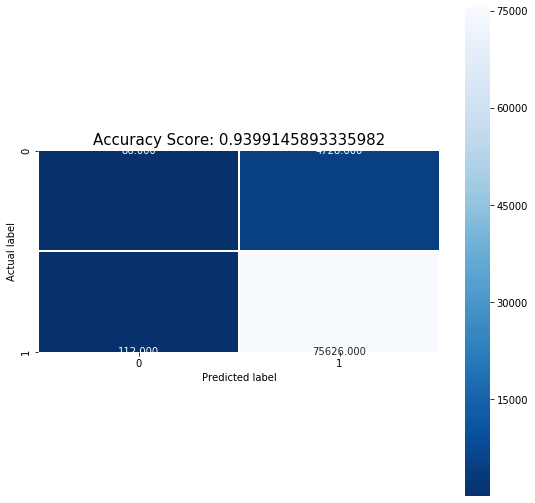

No handles with labels found to put in legend.


[0.89177849 0.87962967 0.91371869 ... 0.8028486  0.87415575 0.8818246 ]


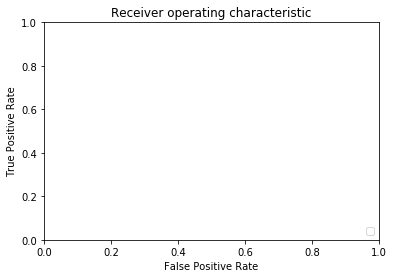

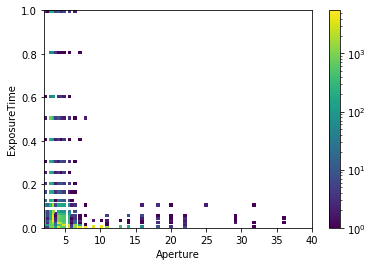

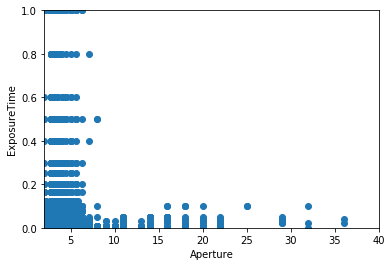

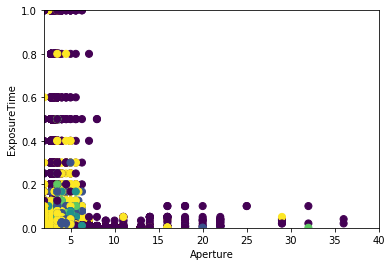

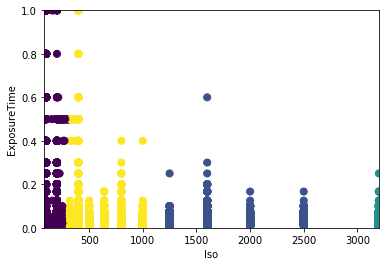

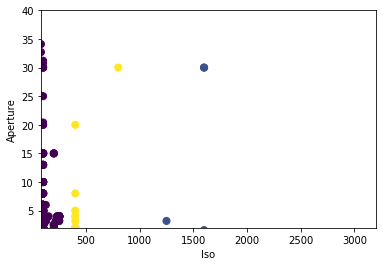

[0 0 0 ... 1 1 1]
Index(['Unnamed: 0', 'SourceFile', 'Date', 'FocalLength in mm', 'ExposureTime',
       'Model', 'ISO', 'Aperture', 'LightValue', 'year', 'dayperiod',
       'CompositePhoto', 'Movie', 'MeasuredEV', 'MeasuredRGGB',
       'WB_RGGBLevelsAsShot', 'ColorTemperature', 'ColorTempDaylight',
       'TimeZone', 'DaylightSavings', 'TimeZoneCity', 'pictureCount',
       'prediction_kmeans'],
      dtype='object') <bound method NDFrame.head of        Unnamed: 0                                         SourceFile  \
0               0  /2006/060710 - London/P7100001 - Basel, Easyje...   
1               1  /2006/060710 - London/P7100002 - London, Leice...   
2               2  /2006/060710 - London/P7100003 - London, House...   
3               3  /2006/060710 - London/P7100004 - London, Westm...   
4               4  /2006/060710 - London/P7100005 - London, St. M...   
...           ...                                                ...   
91783       91783    /2019/190708 CMS/P708

In [73]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
from math import log
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(solver='liblinear',max_iter=100)
logisticRegr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=100)
#logisticRegr = LogisticRegression(class_weight='balanced',solver='newton-cg')
#logisticRegr = LogisticRegression(class_weight='balanced',solver='newton-cg',max_iter=1000)

dataframe_list=[]

data_max=datetime.datetime.now()
datamax=data_max.strftime("%b %d %a ,%Y, %H:%M:%S")
data_min=datetime.datetime.now()
datamin=data_min.strftime("%b %d %a ,%Y, %H:%M:%S")


df=pd.read_csv("EXIFDataCombinedCameras_2006_to_2019_DateLocalTime.csv")
#drop row where any of the values in the specified columns is not filled 
#alternatively drop only if any of those is missing
df_new=df.dropna(axis=0, how='any', subset=['ISO','Aperture','ExposureTime','LightValue','FocalLength in mm'])
df_new=df_new[df_new['Date']!='missing']
df_new=df_new[df_new['Aperture']!='missing']
df_new['Date']=pd.to_datetime(df_new['Date'],format='%b %d %a ,%Y, %H:%M:%S')
df_new['pictureCount']=int(1)
df_new=df_new[df_new['Movie']!=1]
df_new=df_new[df_new['CompositePhoto']!=1]
#df_new=df_new[df_new['ISO']<900]
#replace dayperiod entries with -1 "night" with new category 4
#-1 is night, 0 is light festival/fireworks
#3 is twilight
#2 (sunrise/sunset) and 1 are daytime
df_new=df_new.replace({'dayperiod': {-1: 0}})
df_new=df_new.replace({'dayperiod': {2: 1}})
df_new=df_new.replace({'dayperiod': {3: 0}})
df_target = df_new[['dayperiod']]
df_new_kms = df_new[['ISO', 'Aperture','ExposureTime','LightValue','FocalLength in mm']]
print(df_target.head)
x_train, x_test, y_train, y_test = train_test_split(df_new_kms, df_target, test_size=0.90, random_state=0)
logisticRegr.fit(x_train, y_train)
y_train.to_csv(r'EXIFDataCombinedCameras_2006_to_2019_DateLocalTimeDayTimeTrain.csv')
y_pred = logisticRegr.predict(x_test)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(classification_report(y_test, y_pred))
print(score)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.show()
logit_roc_auc = roc_auc_score(y_test, logisticRegr.predict(x_test))
print(logisticRegr.predict_proba(x_test)[:,1])
#fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict(x_test)[:,1])
#plt.figure()
#plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
kmeans = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
df_test=df_new_kms.astype(float)
#df_test = df_new.apply(pd.to_numeric)
#print(df_test.columns,df_test.head)
plt.xlabel('Aperture')
plt.ylabel('ExposureTime')
plt.hist2d(df_test['Aperture'],df_test['ExposureTime'], bins=[100,100],range=[[2,40],[0,1.0]],norm = colors.LogNorm())
plt.savefig('EXIFDataPlots/PhotosIsoVsLightValueNumPy.pdf')
plt.colorbar()
plt.show()
plt.scatter(df_test['Aperture'],df_test['ExposureTime']);
plt.xlim(2,40)
plt.ylim(0,1.0)
plt.xlabel('Aperture')
plt.ylabel('ExposureTime')
plt.savefig('EXIFDataPlots/PhotosIsoVsLightValueNumPyScatter.pdf')
#plt.colorbar()
plt.show()
X_kms = np.array(df_test)
y_kms = kmeans.fit_predict(X_kms)
plt.scatter(df_test['Aperture'],df_test['ExposureTime'],  c=y_kms, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.xlim(2,40)
plt.ylim(0,1.0)
plt.xlabel('Aperture')
plt.ylabel('ExposureTime')
plt.savefig('EXIFDataPlots/PhotosApertureVsExposureTimeNumPyScatterKMeans.pdf')
plt.show()
plt.scatter(df_test['ISO'],df_test['ExposureTime'],  c=y_kms, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.xlim(80,3200)
plt.ylim(0,1.0)
plt.xlabel('Iso')
plt.ylabel('ExposureTime')
plt.savefig('EXIFDataPlots/PhotosIsoVsExposureTimeNumPyScatterKMeans.pdf')
#plt.colorbar()
plt.show()
plt.scatter(df_test['ISO'],df_test['ExposureTime'],  c=y_kms, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.xlim(80,3200)
plt.ylim(2,40)
plt.xlabel('Iso')
plt.ylabel('Aperture')
plt.savefig('EXIFDataPlots/PhotosIsoVsApertureNumPyScatterKMeans.pdf')
#plt.colorbar()
plt.show()
print (y_kms)
df_new['prediction_kmeans'] = y_kms
print(df_new.columns,df_new.head)
    #print(combine_all_data.head)
df_new.to_csv(r'EXIFDataCombinedCameras_2006_to_2019_DateLocalTimeKMeansPred.csv')